# Will Gasser | Homework 2 | Comp 6630

## README
required imports:
- numpy
- matplotlib
- time

#### I had to mount my google drive, my relative file paths will not work for any other user



In [92]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import time

## Activation Functions
These functions transform the weighted sum of inputs into activations for each neuron. This is just the code implementation for the functions. Once I build our basic perceptron using these functions, I will then comment on the most optimal choice.

In [93]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
    s = sigmoid(Z)
    return s * (1 - s)

def linear(Z):
    return Z

def linear_derivative(Z):
    return np.ones_like(Z)

def tanh(Z):
    return np.tanh(Z)

def tanh_derivative(Z):
    return 1 - np.tanh(Z)**2

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return np.where(Z > 0, 1, 0)

## Network Initialization
These functions initialize our weights and biases and also define our forward pass and loss implementations. Here I wrote the intialize_model function to have a variable amount of neurons in each layer based on our argument inputs. Later I will dicuss how using this approach allowed me to tune my neuron count for optimal training. 

In [94]:
def initialize_model(input_size, hidden_size, output_size):
    """Initialize weights and biases for a neural network with one hidden layer"""
    weights1 = np.random.randn(input_size, hidden_size) * np.sqrt(1 / input_size)
    bias1 = np.zeros((1, hidden_size))
    
    weights2 = np.random.randn(hidden_size, output_size) * np.sqrt(1 / hidden_size)
    bias2 = np.zeros((1, output_size))
    
    return [weights1, weights2], [bias1, bias2]

def forward_pass(X, weights, biases, hidden_activation=sigmoid, output_activation=linear, store_intermediates=False):
    Z1 = np.dot(X, weights[0]) + biases[0]
    A1 = hidden_activation(Z1)
    Z2 = np.dot(A1, weights[1]) + biases[1]
    A2 = output_activation(Z2)
    
    if store_intermediates:
        return A2, [(Z1, A1), (Z2, A2)]
    return A2

def compute_mse_loss(y_pred, y_true):
    m = y_true.shape[0]
    return np.sum((y_pred - y_true) ** 2) / (2 * m)


## Back Propogation
This was the most intensive portion of this exercise. Writing back propogation required me to understand the complexities of the chain rule in relation to adjusting our weights and biases with or previous activations and z's. Once I was able to simplify the notation however, back propogation has a very neat vectorized form. Additionally, this helped bolster my skills in numpy with manipulating matrices. 

In [95]:
def backward_pass(X, y, weights, biases, intermediates, hidden_activation_derivative=sigmoid_derivative, output_activation_derivative=linear_derivative):
    m = X.shape[0]
    Z1, A1 = intermediates[0]
    Z2, A2 = intermediates[1]
    
    dZ2 = (A2 - y) * output_activation_derivative(Z2)  
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    
    # Gradients for hidden layer
    dA1 = np.dot(dZ2, weights[1].T)
    dZ1 = dA1 * hidden_activation_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    return [dW1, dW2], [db1, db2]

def update_parameters(weights, biases, weight_grads, bias_grads, learning_rate):
    for i in range(len(weights)):
        weights[i] -= learning_rate * weight_grads[i]
        biases[i] -= learning_rate * bias_grads[i]
    return weights, biases


## Training Function
This function includes l2 normalization and early stopping. It also allows us to input our custom activation functions to train our model with. 

In [ ]:
def train_model(X_train, Y_train, X_val=None, Y_val=None, hidden_size=10, 
                epochs=1000, learning_rate=0.01, 
                hidden_activation=sigmoid, hidden_activation_derivative=sigmoid_derivative,
                output_activation=linear, output_activation_derivative=linear_derivative,
                early_stopping=False, patience=10, verbose=True, l2_reg=0.0):

    n_samples, input_size = X_train.shape
    _, output_size = Y_train.shape if len(Y_train.shape) > 1 else (n_samples, 1)
    
    Y_train = Y_train.reshape(-1, output_size)
    if Y_val is not None:
        Y_val = Y_val.reshape(-1, output_size)
    
    # Initialize model
    weights, biases = initialize_model(input_size, hidden_size, output_size)
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_weights = None
    best_biases = None
    
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        y_pred, intermediates = forward_pass(
            X_train, weights, biases, 
            hidden_activation, output_activation, 
            store_intermediates=True
        )
        train_loss = compute_mse_loss(y_pred, Y_train)
        
        if l2_reg > 0:
            l2_loss = 0
            for w in weights:
                l2_loss += np.sum(np.square(w))
            train_loss += (l2_reg / (2 * n_samples)) * l2_loss
        
        train_losses.append(train_loss)
        
        weight_grads, bias_grads = backward_pass(
            X_train, Y_train, weights, biases, intermediates,
            hidden_activation_derivative, output_activation_derivative
        )
        
        # L2 regularization for gradients
        if l2_reg > 0:
            for i in range(len(weights)):
                weight_grads[i] += (l2_reg / n_samples) * weights[i]
        
        weights, biases = update_parameters(weights, biases, weight_grads, bias_grads, learning_rate)
        
        if X_val is not None and Y_val is not None:
            val_pred = forward_pass(X_val, weights, biases, hidden_activation, output_activation)
            val_loss = compute_mse_loss(val_pred, Y_val)
            
            # Add L2 regularization to validation loss if enabled
            if l2_reg > 0:
                l2_loss = 0
                for w in weights:
                    l2_loss += np.sum(np.square(w))
                val_loss += (l2_reg / (2 * X_val.shape[0])) * l2_loss
                
            val_losses.append(val_loss)
            
            # Early stopping
            if early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = [w.copy() for w in weights]
                    best_biases = [b.copy() for b in biases]
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        if verbose:
                            print(f"Early stopping at epoch {epoch+1}")
                        weights = best_weights
                        biases = best_biases
                        break
        
        if verbose and (epoch+1) % 100 == 0:
            if X_val is not None and Y_val is not None:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_losses[-1]:.6f}, Time: {time.time() - epoch_start:.2f}s")
            else:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Time: {time.time() - epoch_start:.2f}s")
    
    if verbose:
        print(f"Total training time: {time.time() - start_time:.2f}s")
    
    if early_stopping and best_weights is not None:
        weights = best_weights
        biases = best_biases
    
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses if val_losses else None
    }
    
    return weights, biases, history

def test_model(X, Y, weights, biases, hidden_activation=sigmoid, output_activation=linear):
    Y = Y.reshape(-1, 1) if len(Y.shape) == 1 else Y
    predictions = forward_pass(X, weights, biases, hidden_activation, output_activation)
    mse = compute_mse_loss(predictions, Y)
    return predictions, mse

In [97]:
def reshape_data_for_nn(X_train, Y_train, X_test, Y_test):
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    
    Y_train = Y_train.reshape(-1, 1) if len(Y_train.shape) == 1 else Y_train
    Y_test = Y_test.reshape(-1, 1) if len(Y_test.shape) == 1 else Y_test
    
    return X_train, Y_train, X_test, Y_test

def normalize_data(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std[std == 0] = 1  
    
    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std
    
    return X_train_norm, X_test_norm, mean, std

def split_data(X, Y, validation_ratio=0.2, shuffle=True):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    val_size = int(n_samples * validation_ratio)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]
    
    X_train, X_val = X[train_indices], X[val_indices]
    Y_train, Y_val = Y[train_indices], Y[val_indices]
    
    return X_train, Y_train, X_val, Y_val

In [98]:
def plot_loss_curve(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    if history['val_loss'] is not None:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(X, Y_true, Y_pred, title="Predictions vs True Values"):
    plt.figure(figsize=(12, 10))
    
    ax = plt.subplot(2, 1, 1, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], Y_true, color='blue', label='True Values')
    ax.scatter(X[:, 0], X[:, 1], Y_pred, color='red', alpha=0.5, label='Predictions')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Y')
    ax.set_title('3D Visualization of Predictions')
    ax.legend()
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_learning_rate_curve(learning_rates, losses):
    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates, losses, marker='o')
    plt.xlabel('Learning Rate')
    plt.ylabel('MSE Loss')
    plt.title('Learning Rate vs MSE Loss')
    plt.grid(True)
    plt.xscale('log')
    plt.show()

def plot_neuron_count_curve(neuron_counts, losses):
    plt.figure(figsize=(10, 6))
    plt.plot(neuron_counts, losses, marker='o')
    plt.xlabel('Number of Neurons in Hidden Layer')
    plt.ylabel('MSE Loss')
    plt.title('Hidden Layer Neurons vs MSE Loss')
    plt.grid(True)
    plt.show()

def plot_compare_activations(activation_names, losses):
    plt.figure(figsize=(10, 6))
    plt.bar(activation_names, losses)
    plt.xlabel('Activation Function')
    plt.ylabel('MSE Loss')
    plt.title('Activation Function Comparison')
    plt.grid(True, axis='y')
    plt.show()

## Question 1: Derivation of the Update Rule [10 points]

Derive the update rule and show how to train a 2-layer neural network with backpropagation for regression using the Mean Square Error loss.

### 1. Forward Pass:
- Input X to hidden layer: Z1 = XW1 + b1
- Hidden layer activation: A1 = sigmoid(Z1)
- Output layer: Z2 = A1W2 + b2
- Prediction (linear activation): Y_pred = Z2

### 2. Loss Function (Mean Squared Error):
- MSE = (1/2m) * sum((Y_pred - Y)^2)

### 3. Backward Pass (Computing Gradients):
- dL/dY_pred = (Y_pred - Y)/m
- dL/dZ2 = dL/dY_pred * dY_pred/dZ2 = (Y_pred - Y)/m * 1 = (Y_pred - Y)/m
- dL/dW2 = dL/dZ2 * dZ2/dW2 = (Y_pred - Y)/m * A1 = A1.T * (Y_pred - Y)/m
- dL/db2 = dL/dZ2 * dZ2/db2 = sum((Y_pred - Y)/m, axis=0)
- dL/dA1 = dL/dZ2 * dZ2/dA1 = (Y_pred - Y)/m * W2.T = (Y_pred - Y) * W2.T/m
- dL/dZ1 = dL/dA1 * dA1/dZ1 = dL/dA1 * sigmoid'(Z1) = dL/dA1 * (A1 * (1 - A1))
- dL/dW1 = dL/dZ1 * dZ1/dW1 = dL/dZ1 * X = X.T * dL/dZ1
- dL/db1 = dL/dZ1 * dZ1/db1 = sum(dL/dZ1, axis=0)

### 4. Update Rule:
- W1 = W1 - learning_rate * dL/dW1
- b1 = b1 - learning_rate * dL/db1
- W2 = W2 - learning_rate * dL/dW2
- b2 = b2 - learning_rate * dL/db2

### Difference from Binary Classification with Log Loss:
- With binary classification using log loss (binary cross-entropy), the derivative of loss with 
  respect to output (dL/dY_pred) is different:
  - For MSE: dL/dY_pred = (Y_pred - Y)/m
  - For Binary Cross-Entropy: dL/dY_pred = -(Y/Y_pred - (1-Y)/(1-Y_pred))/m
  
- This difference propagates through the entire backpropagation process, resulting in different 
  update rules. Additionally, for binary classification, the output layer typically uses sigmoid 
  activation instead of linear, which affects the gradients

## Question 2: Implementation and Experiments [50 points]

In [99]:
X_train = np.loadtxt("X_train.csv")
Y_train = np.loadtxt("Y_train.csv")
X_test = np.loadtxt("X_test.csv")
Y_test = np.loadtxt("Y_test.csv")

print("Data loaded successfully!")
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape if isinstance(Y_train, np.ndarray) else (len(Y_train),)}")

X_train, Y_train, X_test, Y_test = reshape_data_for_nn(X_train, Y_train, X_test, Y_test)

# Normalize features
X_train_norm, X_test_norm, mean, std = normalize_data(X_train, X_test)

Data loaded successfully!
X_train shape: (100, 2)
Y_train shape: (100,)


### 1. What is the activation function for the output layer?

In [100]:
hidden_size = 100  # Start with 5 neurons in hidden layer
learning_rate = .1
epochs = 1000

print("Training baseline model with:")
print(f"Hidden layer neurons: {hidden_size}")
print(f"Learning rate: {learning_rate}")
print(f"Epochs: {epochs}")

weights, biases, history = train_model(
    X_train_norm, Y_train,
    hidden_size=hidden_size,
    epochs=epochs,
    learning_rate=learning_rate,
    verbose=True
)

Training baseline model with:
Hidden layer neurons: 100
Learning rate: 0.1
Epochs: 1000


TypeError: initialize_model() takes 3 positional arguments but 4 were given

In [ ]:
test_predictions, test_mse = test_model(X_test_norm, Y_test, weights, biases)
print(f"3. Average MSE Loss on test set: {test_mse:.6f}")

3. Average MSE Loss on test set: 4.433589


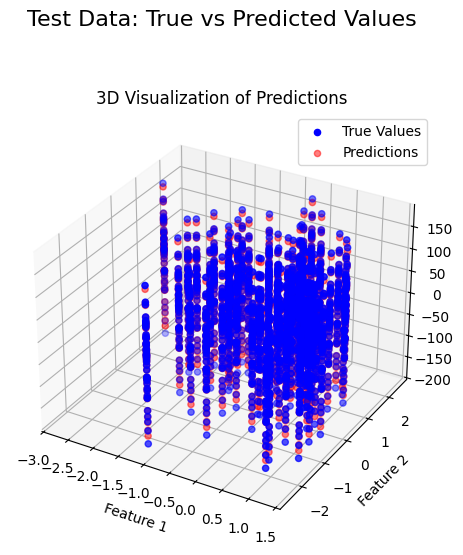

In [ ]:
plot_predictions(X_test, Y_test, test_predictions, "Test Data: True vs Predicted Values")

4. Loss curve:


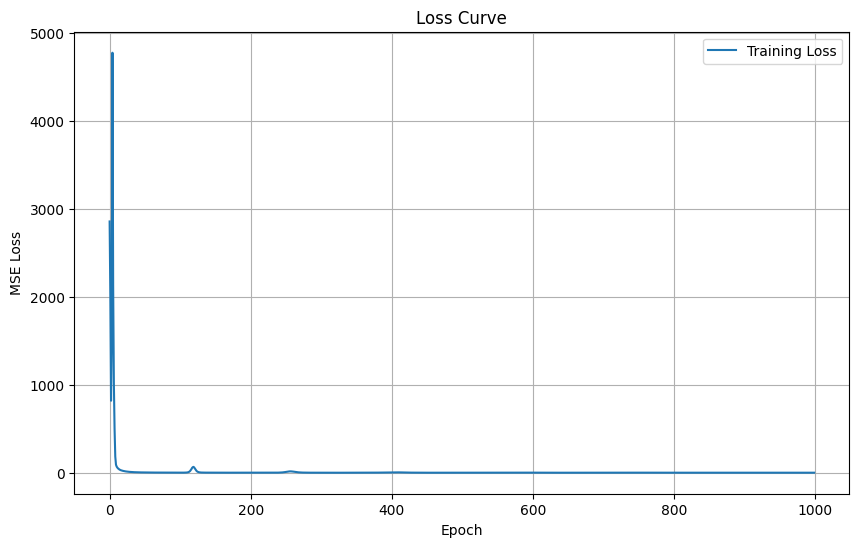

In [ ]:
print("4. Loss curve:")
plot_loss_curve(history)

In [ ]:
print("5. Testing effect of learning rate:")
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
lr_mse_results = []

for lr in learning_rates:
    print(f"  Testing learning rate: {lr}")
    w, b, h = train_model(
        X_train_norm, Y_train,
        hidden_size=hidden_size,
        epochs=epochs,
        learning_rate=lr,
        verbose=False
    )
    
    # Test model
    _, mse = test_model(X_test_norm, Y_test, w, b)
    lr_mse_results.append(mse)
    print(f"  Learning rate {lr}: MSE = {mse:.6f}")

5. Testing effect of learning rate:
  Testing learning rate: 0.001
  Learning rate 0.001: MSE = 111.755621
  Testing learning rate: 0.005
  Learning rate 0.005: MSE = 34.465636
  Testing learning rate: 0.01
  Learning rate 0.01: MSE = 20.271809
  Testing learning rate: 0.05
  Learning rate 0.05: MSE = 4.416491
  Testing learning rate: 0.1
  Learning rate 0.1: MSE = 2.764968
  Testing learning rate: 0.5


C:\Users\willb\AppData\Local\Temp\ipykernel_9368\1325490778.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))
C:\Users\willb\AppData\Local\Temp\ipykernel_9368\342301335.py:23: RuntimeWarning: overflow encountered in square
  return np.sum((y_pred - y_true) ** 2) / (2 * m)
C:\Users\willb\AppData\Local\Temp\ipykernel_9368\595104147.py:12: RuntimeWarning: invalid value encountered in multiply
  dZ1 = dA1 * hidden_activation_derivative(Z1)


  Learning rate 0.5: MSE = nan
  Testing learning rate: 1.0
  Learning rate 1.0: MSE = nan


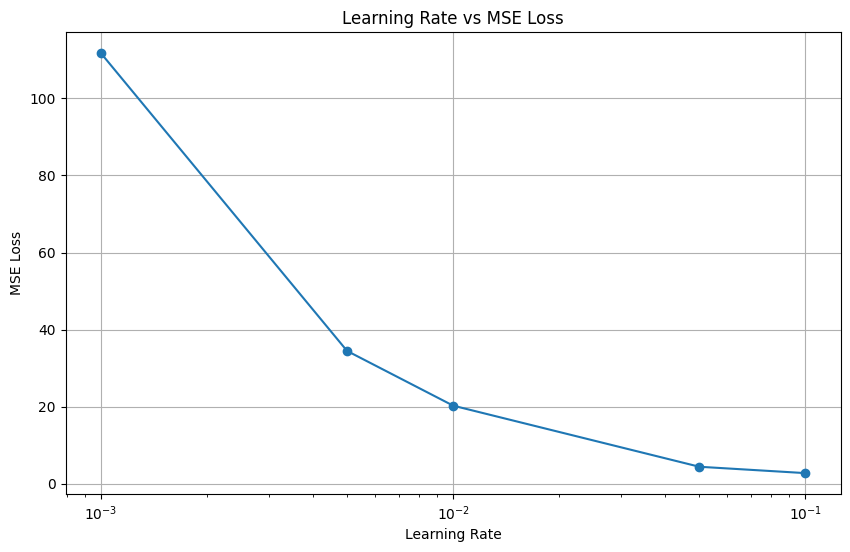

In [ ]:
plot_learning_rate_curve(learning_rates, lr_mse_results)

  Testing with 1 neurons in hidden layer
  1 neurons: MSE = 809.237712
  Testing with 2 neurons in hidden layer
  2 neurons: MSE = 369.502109
  Testing with 3 neurons in hidden layer
  3 neurons: MSE = 291.512166
  Testing with 4 neurons in hidden layer
  4 neurons: MSE = 139.110633
  Testing with 5 neurons in hidden layer
  5 neurons: MSE = 78.446568
  Testing with 6 neurons in hidden layer
  6 neurons: MSE = 34.810627
  Testing with 7 neurons in hidden layer
  7 neurons: MSE = 42.377054
  Testing with 8 neurons in hidden layer
  8 neurons: MSE = 25.669906
  Testing with 9 neurons in hidden layer
  9 neurons: MSE = 22.198700
  Testing with 10 neurons in hidden layer
  10 neurons: MSE = 27.729405
  Testing with 11 neurons in hidden layer
  11 neurons: MSE = 10.999139
  Testing with 12 neurons in hidden layer
  12 neurons: MSE = 12.503184
  Testing with 13 neurons in hidden layer
  13 neurons: MSE = 24.453502
  Testing with 14 neurons in hidden layer
  14 neurons: MSE = 15.141270
  Test

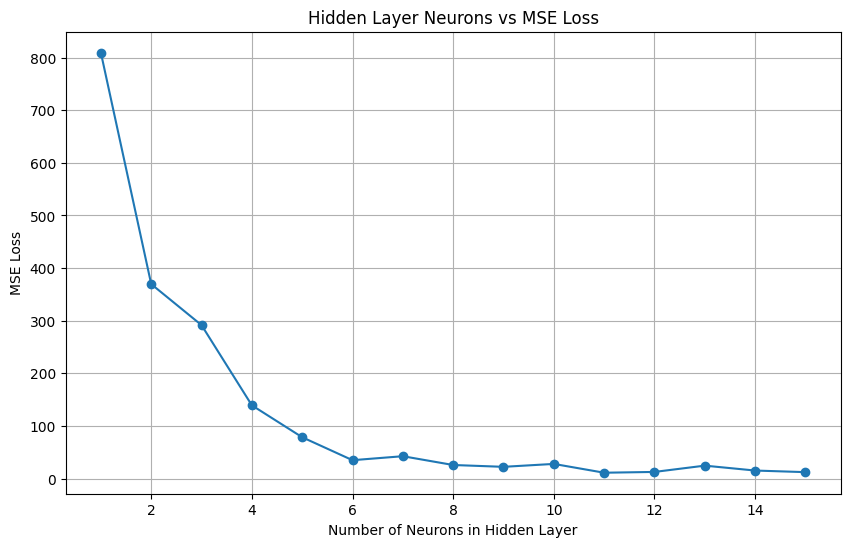

In [ ]:
neuron_counts = list(range(1, 16))
neuron_mse_results = []

for neuron_count in neuron_counts:
    print(f"  Testing with {neuron_count} neurons in hidden layer")
    w, b, h = train_model(
        X_train_norm, Y_train,
        hidden_size=neuron_count,
        epochs=epochs,
        learning_rate=learning_rate,
        verbose=False
    )

    predictions, mse = test_model(X_test_norm, Y_test, w, b)
    neuron_mse_results.append(mse)
    print(f"  {neuron_count} neurons: MSE = {mse:.6f}")
    

plot_neuron_count_curve(neuron_counts, neuron_mse_results)

7. Testing effect of activation functions:
  sigmoid: MSE = 114.162439


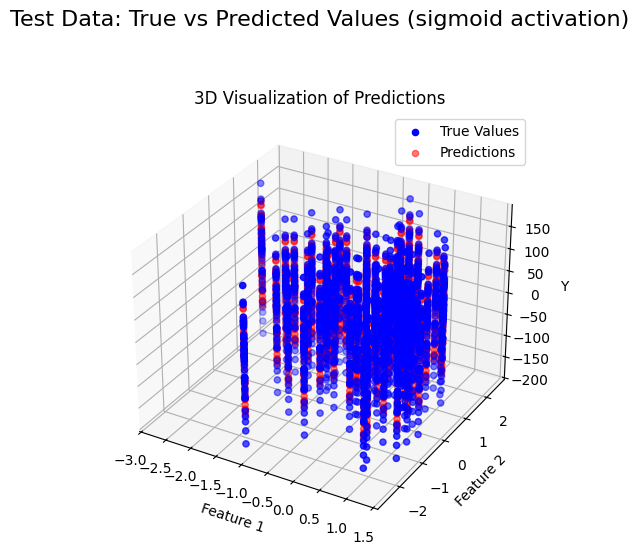

  tanh: MSE = 32.736476


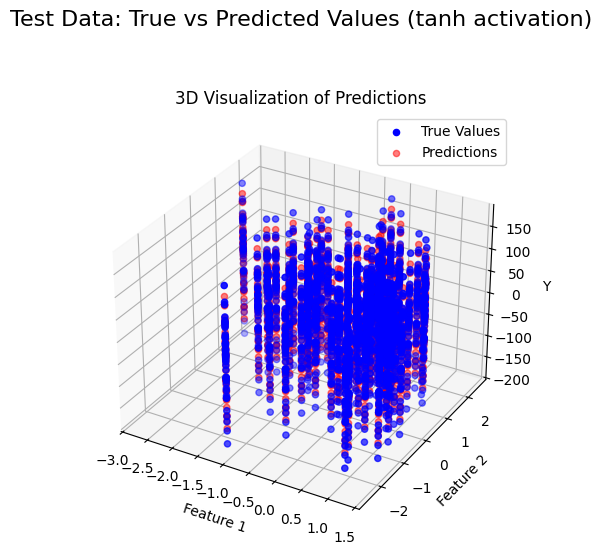

  relu: MSE = 0.552699


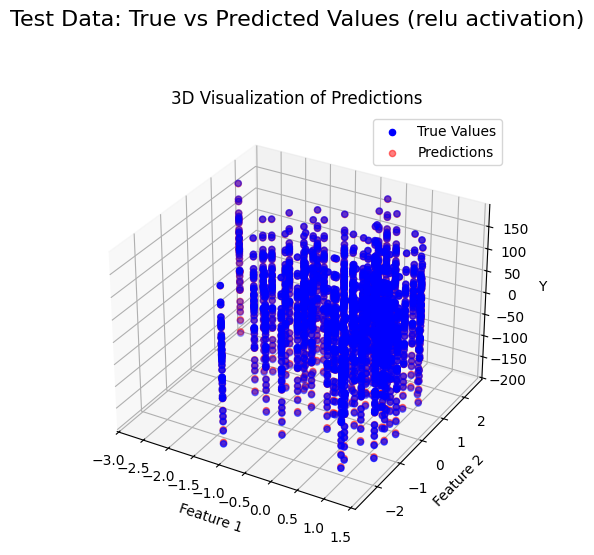

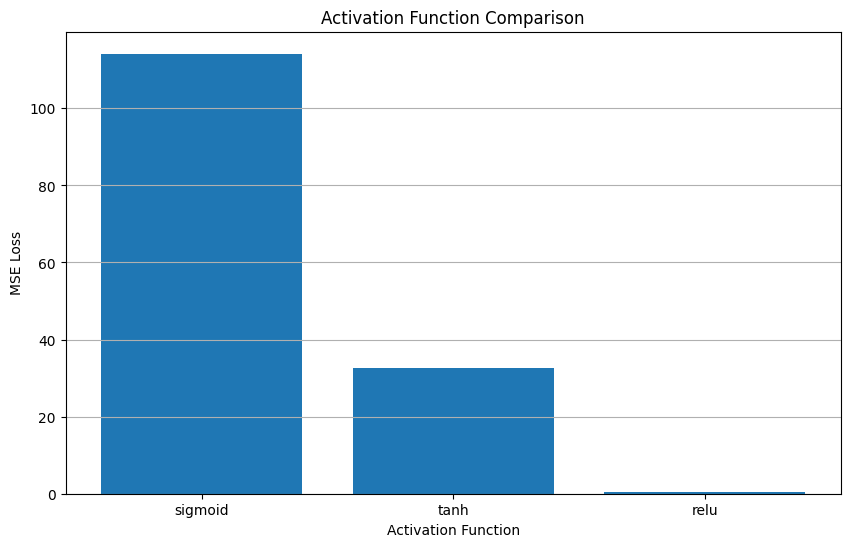

In [ ]:
learning_rate = 0.001

print("7. Testing effect of activation functions:")
activation_funcs = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'tanh': (tanh, tanh_derivative),
    'relu': (relu, relu_derivative)
}

activation_mse_results = {}

for name, (act_func, act_deriv) in activation_funcs.items():
    w, b, h = train_model(
        X_train_norm, Y_train,
        hidden_size=hidden_size,
        epochs=epochs,
        learning_rate=learning_rate,
        hidden_activation=act_func,
        hidden_activation_derivative=act_deriv,
        verbose=False
    )
    
    predictions, mse = test_model(X_test_norm, Y_test, w, b, hidden_activation=act_func)
    activation_mse_results[name] = mse
    print(f"  {name}: MSE = {mse:.6f}")
    
    plot_predictions(
        X_test, Y_test, predictions, 
        f"Test Data: True vs Predicted Values ({name} activation)"
    )

plot_compare_activations(list(activation_mse_results.keys()), list(activation_mse_results.values()))

  Testing with patience = 1


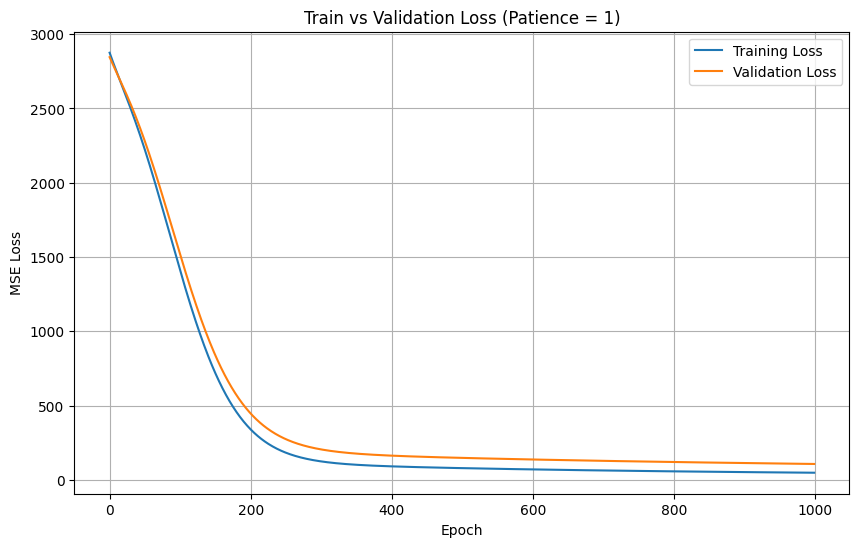

  Patience 1: MSE = 126.148668, Stopped at epoch 1000
  Testing with patience = 5


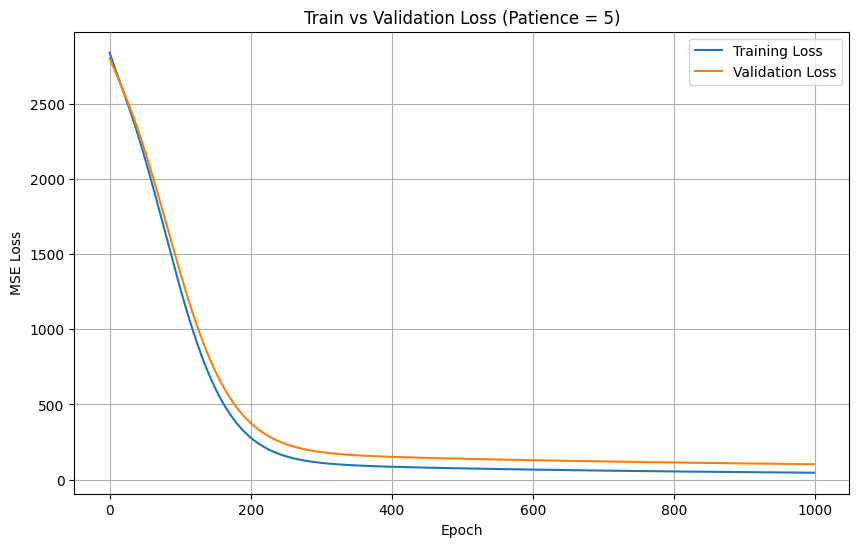

  Patience 5: MSE = 122.246250, Stopped at epoch 1000
  Testing with patience = 10


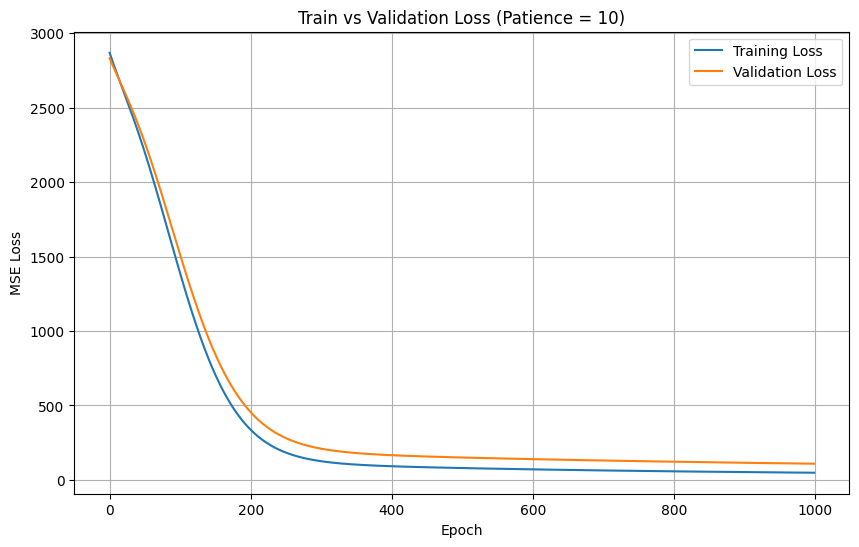

  Patience 10: MSE = 127.914939, Stopped at epoch 1000
  Testing with patience = 20


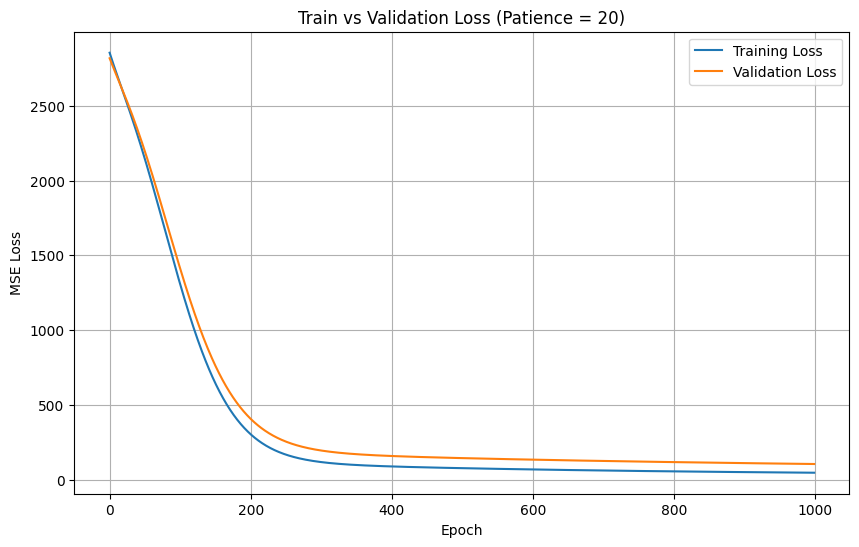

  Patience 20: MSE = 124.469584, Stopped at epoch 1000
  Testing with patience = 50


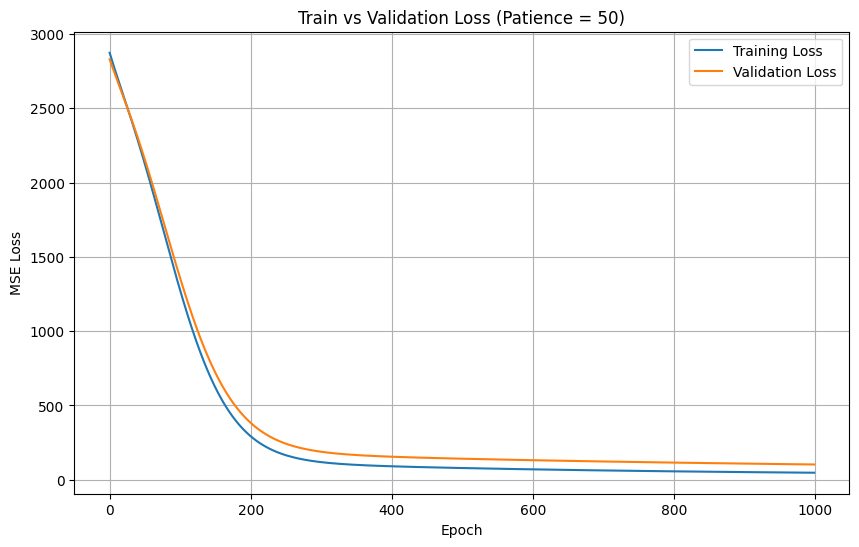

  Patience 50: MSE = 122.285847, Stopped at epoch 1000
  Testing with patience = 100


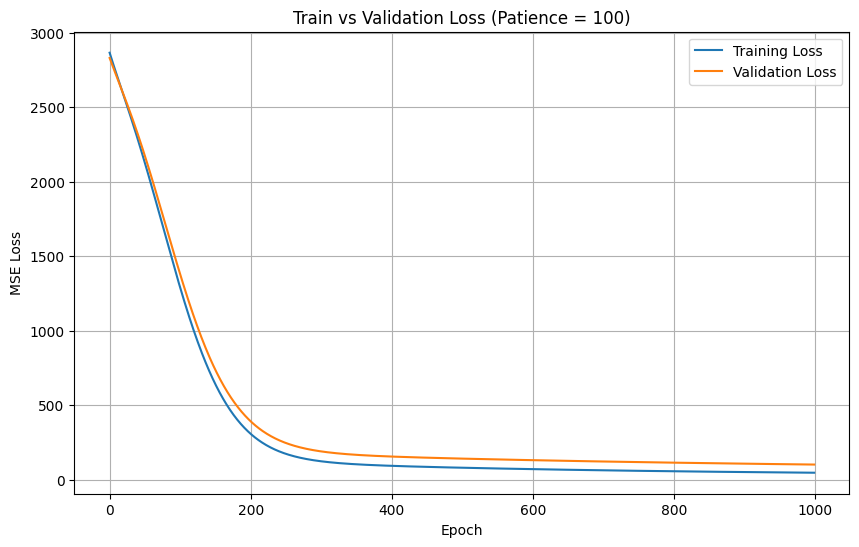

  Patience 100: MSE = 123.569793, Stopped at epoch 1000
  Testing with patience = 500


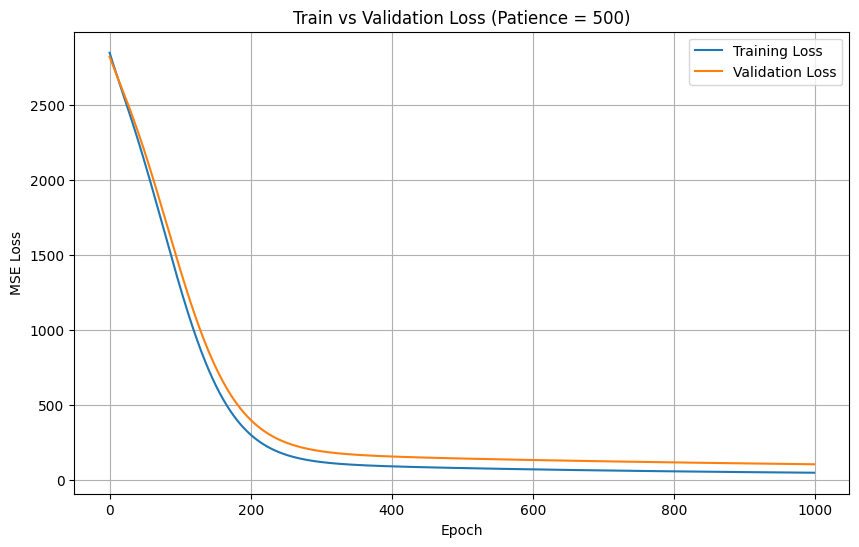

  Patience 500: MSE = 124.427998, Stopped at epoch 1000


In [ ]:
# Split training data into training and validation sets
X_train_split, Y_train_split, X_val, Y_val = split_data(X_train_norm, Y_train, validation_ratio=0.2)

patience_values = [5, 10, 20, 50]
patience_train_losses = {}
patience_val_losses = {}

for patience in patience_values:
    print(f"  Testing with patience = {patience}")
    
    w, b, h = train_model(
        X_train_split, Y_train_split,
        X_val=X_val, Y_val=Y_val,
        hidden_size=hidden_size,
        epochs=2000,  # Increase epochs to see early stopping effect
        learning_rate=learning_rate,
        early_stopping=True,
        patience=patience,
        verbose=False
    )
    
    patience_train_losses[patience] = h['train_loss']
    patience_val_losses[patience] = h['val_loss']
    
    # Plot train vs validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(h['train_loss'], label='Training Loss')
    plt.plot(h['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Train vs Validation Loss (Patience = {patience})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Test model
    _, mse = test_model(X_test_norm, Y_test, w, b)
    print(f"  Patience {patience}: MSE = {mse:.6f}, Stopped at epoch {len(h['train_loss'])}")
